<a href="https://colab.research.google.com/github/VictorNigretto/ProjetLong/blob/main/Segmentation_avec_superpixels_%2B_mean_color_%2B_shadow_removal_%2B_colornames.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import management


In [1]:
import os
import shutil
from tensorflow.python.client import device_lib
import keras
from keras import layers, models, optimizers
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Dense, Flatten, Dropout, Input
from keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.applications import EfficientNetB7, ResNet50
from keras.preprocessing import image
from keras.models import Model
from keras.callbacks import LearningRateScheduler
import pandas as pd
import tensorflow as tf
import numpy as np
from keras.preprocessing.image import load_img
from PIL import Image
from keras.utils import to_categorical 
import cv2
from google.colab.patches import cv2_imshow
import random
from keras.preprocessing.image import load_img
from skimage.transform import rescale, resize, downscale_local_mean
from skimage.filters import sobel
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
from skimage.color import rgb2gray
import matplotlib.pyplot as plt

Upload files

In [2]:
from google.colab import files
uploaded = files.upload()

Saving 100_0001_0116.JPG to 100_0001_0116.JPG


In [10]:
uploaded = files.upload()

Saving 100_0001_0001.JPG to 100_0001_0001.JPG
Saving 100_0001_0002.JPG to 100_0001_0002.JPG
Saving 100_0001_0003.JPG to 100_0001_0003.JPG
Saving 100_0001_0004.JPG to 100_0001_0004.JPG


Load basic image and resize

In [3]:
# image de base
image = load_img('100_0001_0116.JPG')
print("Image shape : ", np.shape(image))
image = np.array(image)
# image : l'image de  base resize
image = rescale(image, 0.10, multichannel=True, anti_aliasing=True)

Image shape :  (3648, 5472, 3)


Display image

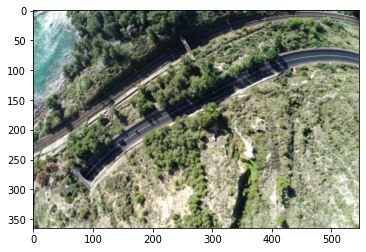

image reshaped shape :  (365, 547, 3)


In [4]:
plt.imshow(image)
plt.show()
print("image reshaped shape : ", np.shape(image))

Segmentation with quickshift

Quickshift number of segments: 376


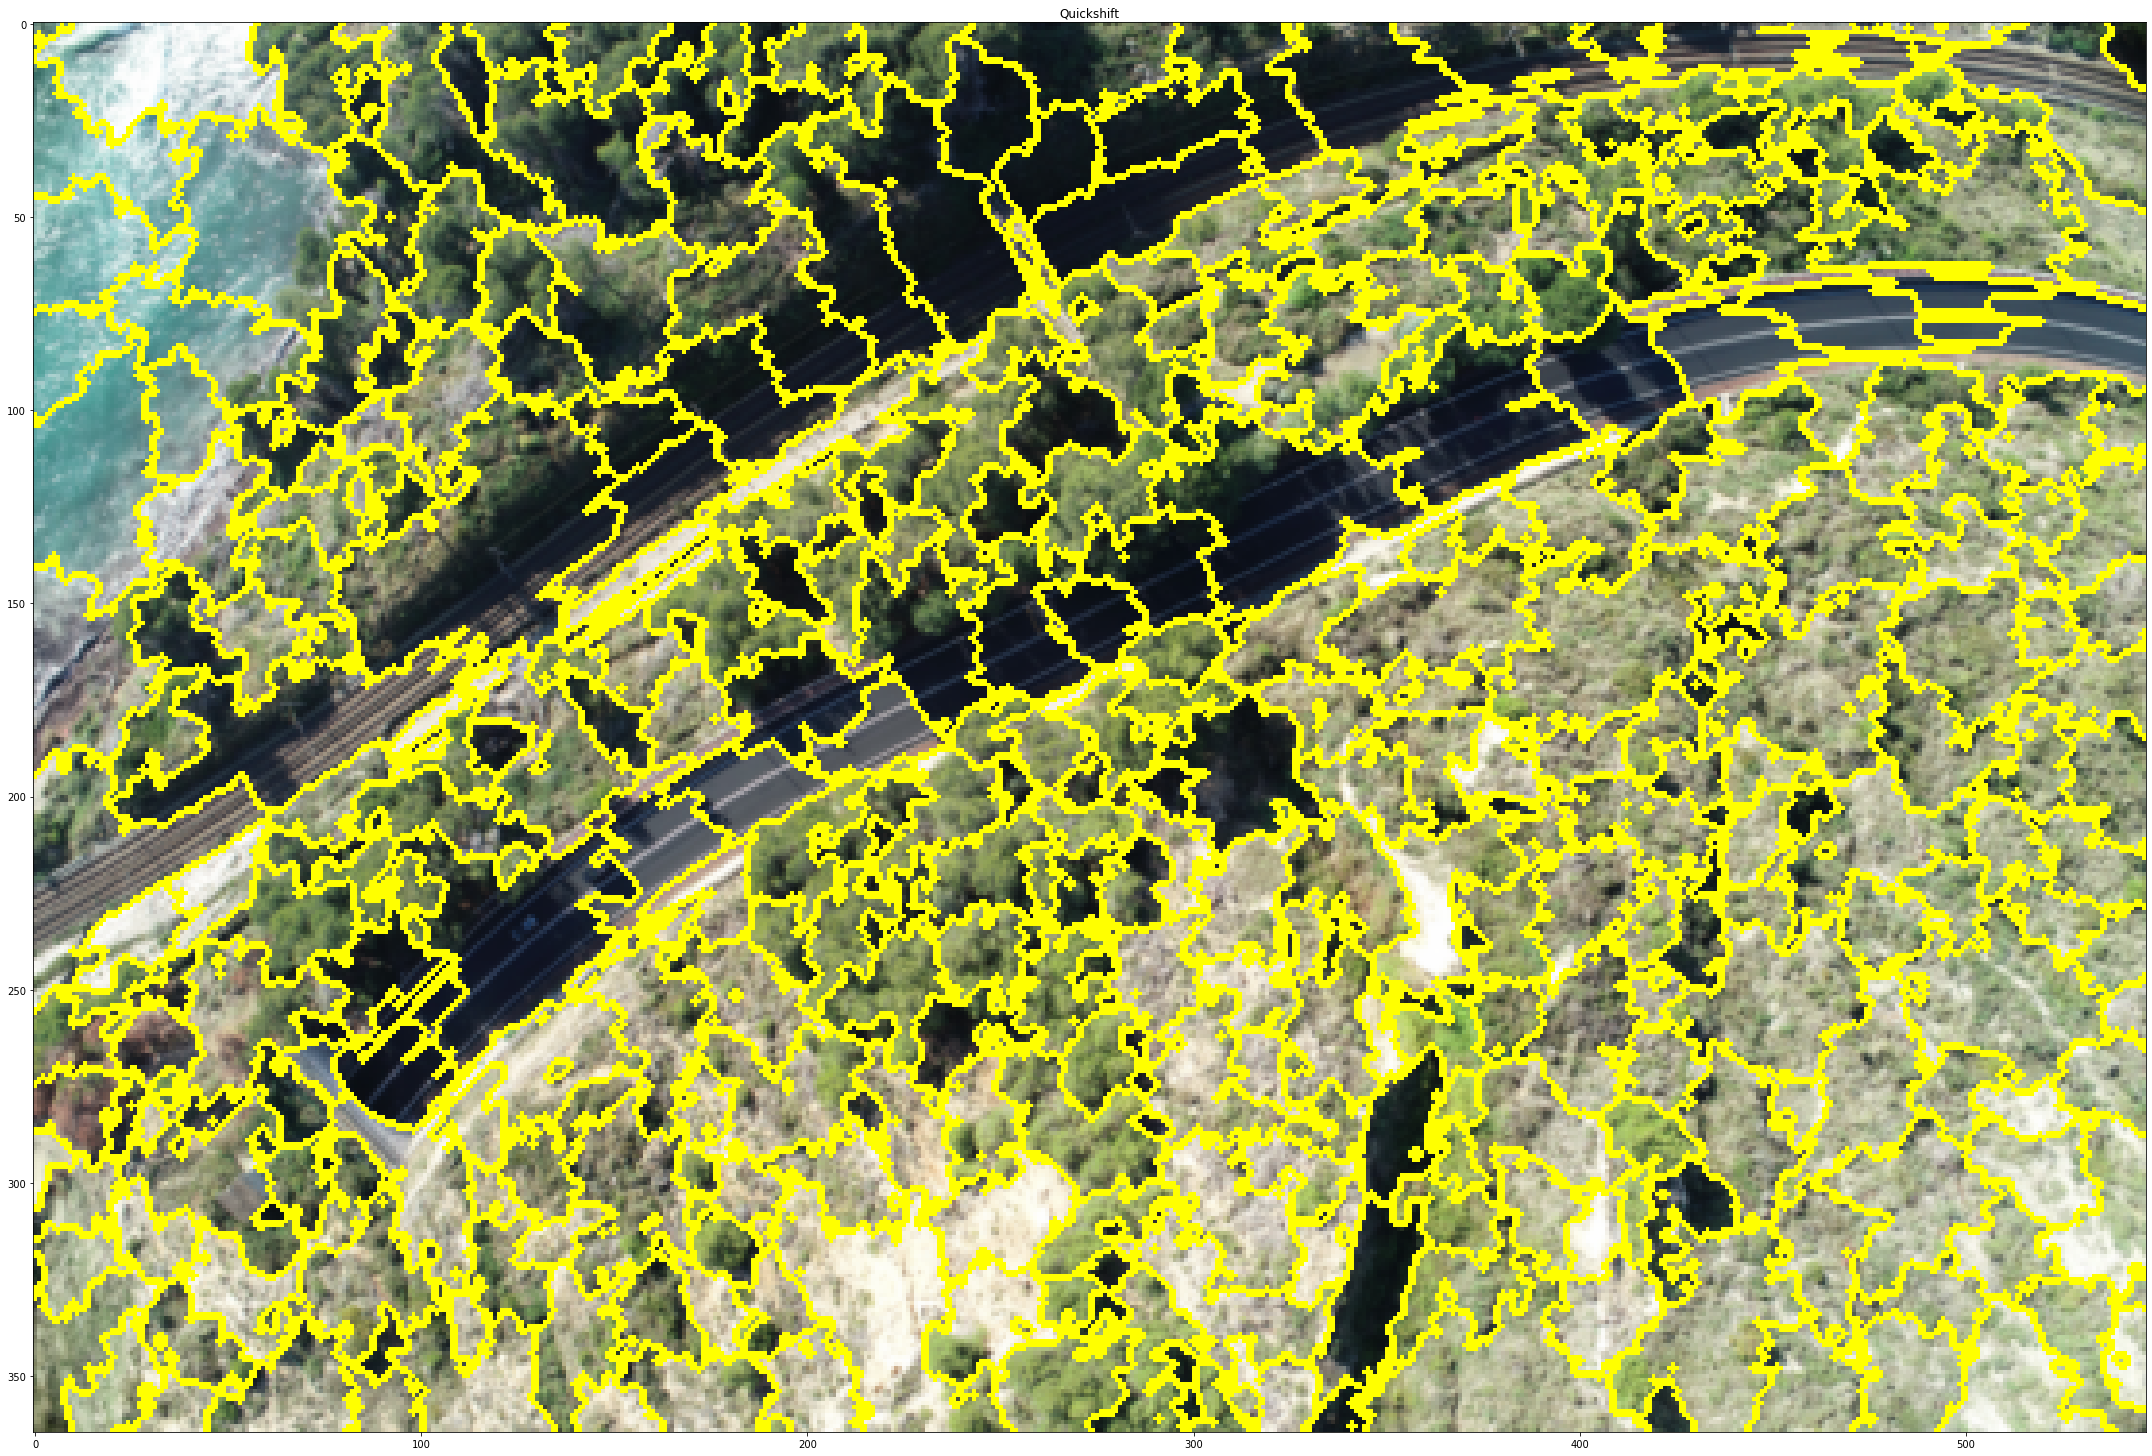

In [5]:
# Passage de l'image en float pour quickshift
img = img_as_float(image)

# segments_quick c'est l'image labélisée par super pixels
segments_quick = quickshift(img, kernel_size=3, max_dist=20, ratio=0.5)

#gradient = sobel(rgb2gray(img))
#segments_watershed = watershed(gradient, markers=250, compactness=0.001)

print(f"Quickshift number of segments: {len(np.unique(segments_quick))}")
#print(f"Compact Watershed number of segments: {len(np.unique(segments_watershed))}")
fig, ax = plt.subplots(1, 1, figsize=(30, 30), sharex=True, sharey=True)

# Fonction sklearn qui affiche les superpixels
ax.imshow(mark_boundaries(img, segments_quick))
ax.set_title('Quickshift')

#ax[1].imshow(mark_boundaries(img, segments_watershed))
#ax[1].set_title('Compact watershed')


plt.tight_layout()
plt.show()

Mean color function

In [13]:
def mean_color(image=image, segments=segments_quick):
  img_reshaped = image.reshape((image.shape[0]*image.shape[1],image.shape[2]))
  print("img reshaped shape", np.shape(img_reshaped))

  segments_reshaped = np.reshape(segments, -1)    
  print("segment reshaped shape", np.shape(segments_reshaped))

  unique_segments = np.unique(segments_reshaped)
  print("unique segment shape", np.shape(unique_segments))
  img_temp = np.zeros(img_reshaped.shape)
  means_values = []

  for i in unique_segments:
    loc=np.where(segments_reshaped==i)[0]
    #print(loc)
    means=np.mean(img_reshaped[loc, :], axis=0)
    means_values.append(means)
    img_temp[loc, :] = means

  return np.reshape(img_temp, [image.shape[0], image.shape[1], image.shape[2]]), means_values

In [14]:
# mean_img : l'image des couleurs moyennes
mean_img, means = mean_color(image, segments_quick)

img reshaped shape (199655, 3)
segment reshaped shape (199655,)
unique segment shape (376,)


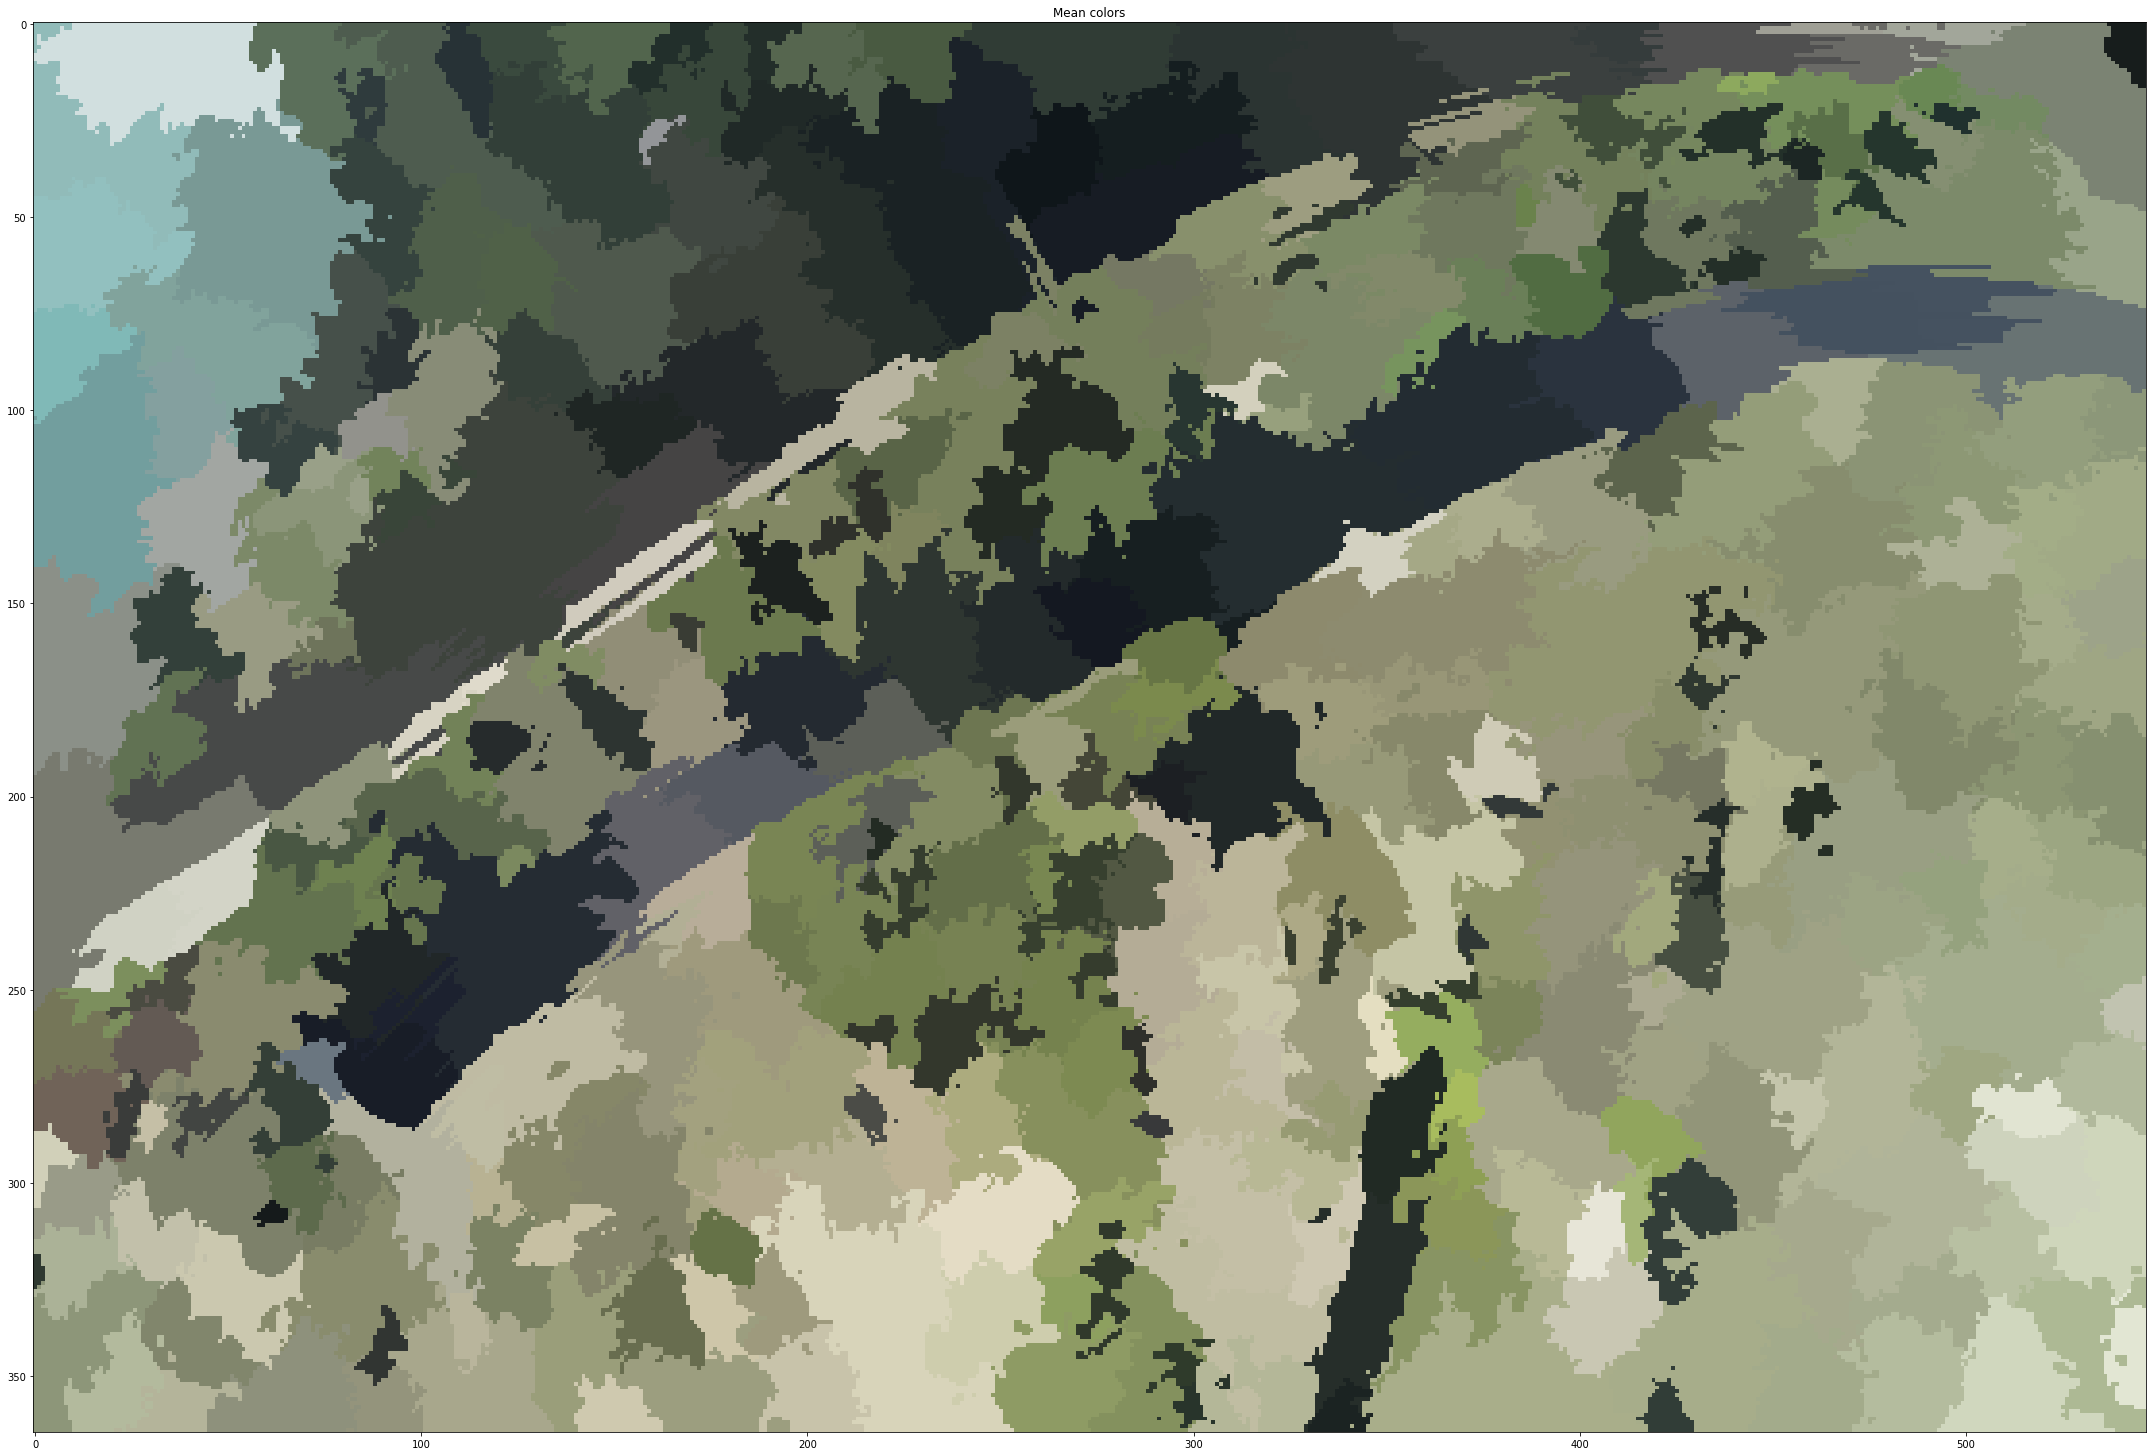

In [15]:
# Affichage
fig, ax = plt.subplots(1, 1, figsize=(30, 30), sharex=True, sharey=True)

#ax[0].imshow(image)
#ax[0].set_title('Original resized image')

ax.imshow(mean_img)
ax.set_title('Mean colors')

plt.tight_layout()
plt.show()


Color_names function

In [16]:
def colornames(image=image, segments=segments_quick):
  img_reshaped = image.reshape((image.shape[0]*image.shape[1],image.shape[2]))
  print("img reshaped shape", np.shape(img_reshaped))

  segments_reshaped = np.reshape(segments, -1)    
  print("segment reshaped shape", np.shape(segments_reshaped))

  unique_segments = np.unique(segments_reshaped)
  print("unique segment shape", np.shape(unique_segments))
  img_temp = np.zeros(img_reshaped.shape)


  colors = np.array([[0, 255, 255], [0, 0, 0], [0, 0, 255], [255, 0, 255], [128, 128, 128], [0, 128, 0], [0, 255, 0], [128, 0, 0], [0, 0, 128], [128, 128, 0], [128, 0, 128], [255, 0, 0], [192, 192, 192], [0, 128, 128], [255, 255, 255], [255, 255, 0]] )
  hist = np.zeros((unique_segments.shape[0],16))
  for id, i in enumerate(unique_segments):
    loc=np.where(segments_reshaped==i)[0]
    for jd, j in enumerate(loc) :
      dist = colors/255 - img_reshaped[j, :]
      dist = np.sum(np.power(dist,2),1)
      index = np.argmin(dist)
      hist[id][index]+=1
    #print(hist[id])
      
    #print(loc)

  return hist